# eXtreme Gradient Boosting (XGBoost)

**References:**
- <https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/>

---

**Aim:**
To investigate if using a more complex model such as XGBoost could yield us better results.

---

After having built the models, we see that we are getting around 0.8 R<sup>2</sup> Variance on the Decision Tree Regressor, 58% Classification accuracy on the Decision Tree Classifier for test set prediciton. The results are acceptable for the Regressor but is lacking for the Classifier. Decision Trees are a very simple model and they have a very high relience on a single variable year, so we should try a different model to see if it yields a better result.  oull

We have learnt that decision trees are greedy and deterministic, thus there is a tendency of overfitting of train data such that the performance of the tree on train data is bad. Decision tree classifies based on what the model thinks is important, there are variables that are hard to classify, causing overfiting. A weak learner occurs when the feature of the model is hard to classify, such as those leaf nodes with high gini index, causing the performance to only be slightly better than a arbitary guess. XGBoost overcomes this weakness by putting more weights on the hard to classify nodes and less on nodes that have a low gini index. Allowing the model to achieve a overall higher accuracy. Minimisation of loss in model identifying weak learners by using a gradient descent.

In [ ]:
## imports
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from IPython.display import Image, display_svg, SVG
sb.set() # set the default Seaborn style for graphics

# Import the required function from sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LinearRegression
from sklearn import tree as sktree
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error,accuracy_score,mean_absolute_error
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support

# Import xboost
import xgboost as xgb
import multiprocessing

In [2]:
import zipfile
import os.path
# Here we use the python package to open the zip file such that there is no need to unzip it
# Note that we are using the cleaned set of data we have processed in the previous notebook
# If you did not run the last line, no worries as the cleaned set is also in the zip
if not os.path.isfile('craigslist-carstrucks-data/vehicles.csv'):
   with zipfile.ZipFile("craigslist-carstrucks-data/vehicles.zip") as z:
      with z.open("carData_clean.csv") as f:
         carData_clean = pd.read_csv(f)
else:
# If you extracted the csv file, use the following code to read the csv
   carData_clean = pd.read_csv("craigslist-carstrucks-data/vehicles.csv")

carData_clean.head()

,price,year,manufacturer,condition,odometer,state,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,...,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_NOTKNOWN,drive_fwd,drive_rwd,PRICECATEGORY
0,10.421984,2014.0,14,3,10.966870,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,9
1,10.025263,2010.0,7,3,11.173656,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7
2,10.586332,2020.0,7,3,9.860580,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,10
3,10.341420,2017.0,39,3,10.624348,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,9
4,9.615805,2013.0,13,1,11.759786,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5


# Exploratory question
**Main problem:** How different variables such as [odometer, year, condition, fuel, title_status, transmission, drive, state, brand] affect the resale price of a car.

**Subproblem 1**: How do different models (Tree regressor, linear regression, tree classifier) repond to the variables.  

**Subproblem 2**: Does applying feature engineering to the dataset change the way the model respond (Tree regressor, linear regression, tree classifier) to the dataest.  

**Subproblem 3**: Is there a better model (XGBoost) we can use to better predict the price of the car.  

## Recap
Main problem: How different variables such as [odometer, year, condition, fuel, title_status, transmission, drive, state, manufacturer] affect the resale price of a car


**Subproblem 3: Is there a better model (XGBoost) we can use to better predict the price of the car**

# XGB Regressor

In [3]:
train_tree, test_tree = train_test_split(carData_clean, test_size = 0.2, random_state=0)
x_train = train_tree.drop(columns=['price','PRICECATEGORY'])
y_train = train_tree[['PRICECATEGORY']].astype(int)
x_test = test_tree.drop(columns=['price','PRICECATEGORY'])
y_test = test_tree[['PRICECATEGORY']].astype(int)

In [4]:
# ---- learning something new and doing something beyond this course ----
# ---- data-driven insights and the recommendations ----

# We import the xgboost python package which is a
# supervised learning algorithm using boosted gradient trees
# https://xgboost.readthedocs.io/en/stable/
n_jobs = multiprocessing.cpu_count()-1

# Creating depths in intervals of 5 (1, 5, 10, 15, 20, 25)
# We will iterate through the the different depths for the XGBoost
# to identify the optimal depth of the tree 
depths = [x for x in range(1,26) if x == 1 or x % 5 == 0]

# Placeholders to save the data for printing and visualisation
xgbSets = []
resultSets = []
kfoldResult = []

# Iterate through the depths and make models
for depth in depths:

    # ---- Creating XGboost regression model ----
    # regression based on squarederror as that is the same as we have used for tree regression

    # create dMatrix dataset which is used by xgb for efficiency
    train_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
    test_dmatrix = xgb.DMatrix(data=x_test,label=y_test)

    # tuned hyper-parameters for speed and efficiency
    params = {"objective":"reg:squarederror", "random_state":0, "max_depth":depth, \
        "tree_method":'hist', "single_precision_histogram":True, \
        "eta": 0.3, "n_jobs":n_jobs, "subsample":0.8}
    # using xgb native API to train and fit model as it is more efficient than using sklearn xgb wrapper API
    xgb_model = xgb.train(dtrain=train_dmatrix, params=params, num_boost_round=25)


    # Here we get the model to predict the price category with the given data
    # we store the predicted values into dataframe "results"
    results_xgb=pd.DataFrame(xgb_model.predict(test_dmatrix),columns=['predict'])
    results_xgb['actual']=list(test_tree.copy()['PRICECATEGORY'])
    
    # Clamping
    # We restrict the price cateogry back to range of 0 - 10
    # For any prediction above 10, we set the prediction to 10
    # Similarly, for prediction below 0, we set the prediction to 0
    # This happens as we are using a regressor for prediction which does not have a class constraint
    results_xgb[results_xgb['predict'] > 10] = 10 
    results_xgb[results_xgb['predict'] < 0] = 0 

    print("Done fitting a xgb model with depth {} ".format(depth))

    # K-fold validation
    # Here we split the train set into 5 splits and shuffle the splits to evaluate whether there is a large standard deviation between the sets
    # This would show any issues in our set due to random biasness or if our model is overfitted
    cv_results = xgb.cv(dtrain=train_dmatrix, params=params, nfold=5,
                    num_boost_round=25,early_stopping_rounds=3,metrics="rmse", as_pandas=True, seed=0)
    print("Done CV with depth {} ".format(depth))

    # Append all results into lists for printing later
    xgbSets.append(xgb_model)
    resultSets.append(results_xgb)
    kfoldResult.append(cv_results)

C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 1 
Done CV with depth 1 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 5 
Done CV with depth 5 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 10 
Done CV with depth 10 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 15 
Done CV with depth 15 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 20 
Done CV with depth 20 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 25 
Done CV with depth 25 


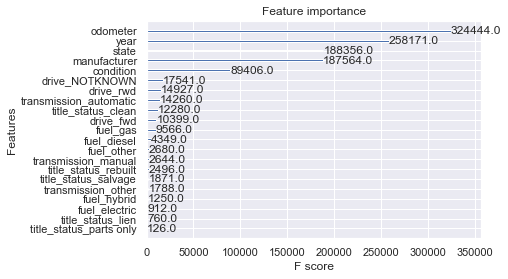

In [5]:
# ---- Feature importance for XGB Regressor ----
xgb.plot_importance(xgb_model)
plt.show()

## Observations

XGB Regressor increase in quality of predictions starts diminishing after depth 15, where R<sup>2</sup> starts to level out towards 0.86 and RMSE starts to level out at 1.0

In [6]:
print("_______________Overall Fit of the model for all test set_______________")

goFString ="Goodness of Fit of Model       " 
r2String  ="Explained Variance (R^2)       "
maeString = "Mean Absolute Error (MAE)      "
mseString = "Mean Squared Error (MSE)       "
rmseString = "Root Mean Squared Error (RMSE) "

for resultSet, depth in zip(resultSets, depths):
      goFString += "| Dataset {} \t".format(depth)
      r2String += "| {:^2.9f} \t".format(metrics.r2_score(resultSet['actual'], resultSet['predict']))
      maeString += "| {:^2.9f} \t".format(metrics.mean_absolute_error(resultSet['actual'], resultSet['predict']))
      mseString += "| {:^2.9f} \t".format(metrics.mean_squared_error(resultSet['actual'], resultSet['predict']))
      rmseString += "| {:^2.9f} \t".format(np.sqrt(metrics.mean_squared_error(resultSet['actual'], resultSet['predict'])))

# ---- Printing the concatenated metric strings for overall ----

print(goFString)
print(r2String)
print(maeString)
print(mseString)
print(rmseString)

_______________Overall Fit of the model for all test set_______________
Goodness of Fit of Model       | Dataset 1 	| Dataset 5 	| Dataset 10 	| Dataset 15 	| Dataset 20 	| Dataset 25 	
Explained Variance (R^2)       | 0.663252343 	| 0.774565730 	| 0.823831519 	| 0.857271559 	| 0.864697331 	| 0.862987204 	
Mean Absolute Error (MAE)      | 1.321129207 	| 1.013533151 	| 0.860686837 	| 0.716969854 	| 0.625909339 	| 0.594697050 	
Mean Squared Error (MSE)       | 2.789484640 	| 1.867079556 	| 1.458822032 	| 1.182041092 	| 1.121207734 	| 1.135262495 	
Root Mean Squared Error (RMSE) | 1.670175033 	| 1.366411196 	| 1.207817052 	| 1.087217132 	| 1.058870971 	| 1.065486976 	


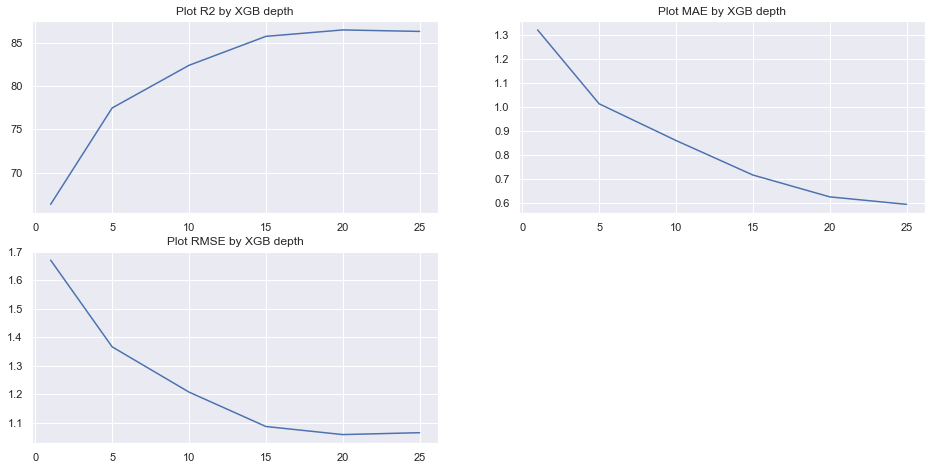

In [7]:
# visualizing the metrics on a line plot sorted by depth
# here we prepare the metrics into a list for plotting
r2 = [metrics.r2_score(resultSet['actual'], resultSet['predict']) * 100 for resultSet in resultSets]
mae = [metrics.mean_absolute_error(resultSet['actual'], resultSet['predict'])  for resultSet in resultSets]
rmse = [np.sqrt(metrics.mean_squared_error(resultSet['actual'], resultSet['predict']))  for resultSet in resultSets]

# creating sub plots for visualization
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
y_dict = {"R2":r2, "MAE":mae,"RMSE":rmse}
i = 0
for row in axes:
    for ax in row:
        if(i >= len(y_dict)):
            ax.remove()
            continue
        key = list(y_dict.keys())[i]
        ax.plot(depths, y_dict[key])
        ax.set_title("Plot " + key + " by XGB depth")
        i += 1
plt.show()

The results from cross-validation shows that the parameters we have chosen for the model are generally fitting as there is very little standard deviation between each fold evaluation

In [8]:
#retrieve the final boosting metric from cross validation
for i, kfold in enumerate(kfoldResult):
    print("Depth " + str(depths[i]) + ":")
    display(kfoldResult[i].tail(1))

Depth 1:


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
24,1.670726,0.002273,1.671159,0.005447


Depth 5:


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
24,1.359395,0.003483,1.365927,0.00695


Depth 10:


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
24,1.122791,0.005034,1.210167,0.004525


Depth 15:


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
24,0.742302,0.003077,1.114034,0.005198


Depth 20:


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
24,0.366583,0.00782,1.093311,0.003755


Depth 25:


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
19,0.243713,0.003678,1.100571,0.006967


## Observations
XGB Regressor generally performs better than Decision Tree Regressor and Linear Regressor. At all depths, the RMSE for XGB is lower than the other two and the R<sup>2</sup> Variance is also higher, indicating a higher prediction accuracy.

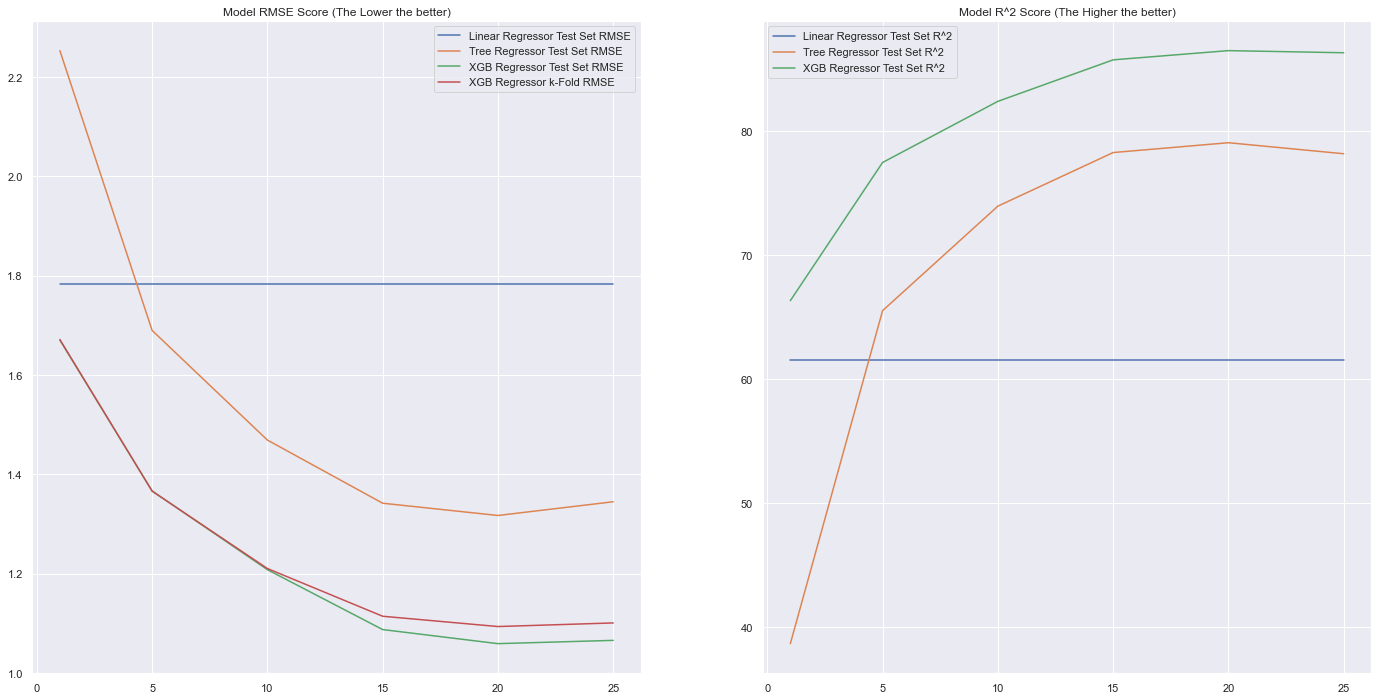

In [9]:
tree_regressor_rmse = []
tree_regressor_r2 = []
linreg_rmse = []
linreg_r2 = []

# create decision tree regressors for comparison
for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=0)
    tree.fit(x_train,y_train)
    results=pd.DataFrame(tree.predict(x_test),columns=['predict'])
    results['actual']=list(test_tree['PRICECATEGORY'])
    tree_regressor_rmse.append(np.sqrt(metrics.mean_squared_error(results['actual'], results['predict'])))
    tree_regressor_r2.append(metrics.r2_score(results['actual'], results['predict']) * 100)

    linreg = LinearRegression()
    linreg.fit(x_train,y_train)
    results=pd.DataFrame(linreg.predict(x_test),columns=['predict'])
    results['actual']=list(test_tree['PRICECATEGORY'])
    linreg_rmse.append(np.sqrt(metrics.mean_squared_error(results['actual'], results['predict'])))
    linreg_r2.append(metrics.r2_score(results['actual'], results['predict']) * 100)



# visualizing the comparison of test set RMSE value versus k-fold RMSE on a line plot 
kfoldResultMean = [result["test-rmse-mean"].tail(1) for result in kfoldResult]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
axes[0].plot(depths, linreg_rmse, label = "Linear Regressor Test Set RMSE")
axes[0].plot(depths, tree_regressor_rmse, label = "Tree Regressor Test Set RMSE")
axes[0].plot(depths, rmse, label = "XGB Regressor Test Set RMSE")
axes[0].plot(depths, kfoldResultMean, label = "XGB Regressor k-Fold RMSE")
axes[0].set_title("Model RMSE Score (The Lower the better)")
axes[0].legend()

axes[1].plot(depths, linreg_r2, label = "Linear Regressor Test Set R^2")
axes[1].plot(depths, tree_regressor_r2, label = "Tree Regressor Test Set R^2")
axes[1].plot(depths, r2, label = "XGB Regressor Test Set R^2")
axes[1].set_title("Model R^2 Score (The Higher the better)")
axes[1].legend()
plt.show()

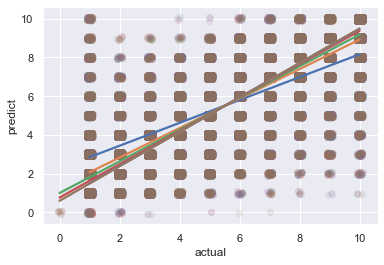

In [10]:
# Scatter plot of prediction vs actual across all datasets combined
for resultSet in resultSets:
    sb.regplot(x = resultSet['actual'].astype(int),y=resultSet['predict'].round(0),x_jitter=.1,y_jitter=.1, scatter_kws={'alpha':0.1})

# XGB Classifier

In [11]:
# Creating depths in intervals of 5 (1, 5, 10, 15, 20, 25)
# We will iterate through the the different depths for the XGBoost
# to identify the optimal depth of the tree 
depths = [x for x in range(1,26) if x == 1 or x % 5 == 0]

# Placeholders to save the data for printing and visualisation
xgbSets = []
resultSets = []
kfoldResult = []

# Iterate through the depths and make models
for x in depths:

    # ---- Creating XGboost Classification model ----
    # Classification based on Multiclass:softmax, evaluated by log_loss

    #create dMatrix dataset which is used by xgb for efficiency
    #label is required to start from index 0, our PRICECATEGORY starts from index 1
    train_dmatrix = xgb.DMatrix(data=x_train,label=y_train - 1)
    test_dmatrix = xgb.DMatrix(data=x_test,label=y_test - 1)

    params = {"objective":"multi:softmax", "random_state":0, "max_depth":x, "eval_metric":'mlogloss', "num_class":10, "tree_method":'hist', "single_precision_histogram":True, \
        "eta": 0.3, "n_jobs":n_jobs, "subsample":0.8}
    xgb_model_classifier = xgb.train(dtrain=train_dmatrix, params=params, num_boost_round=25)

    # copy test set to use for xgb
    car_test_xgb = test_tree.copy()
    car_test_xgb['PRICECATEGORY'] = car_test_xgb['PRICECATEGORY'].astype(int) - 1

    # Here we get the model to predict the price category with the given data
    # we store the predicted values into dataframe "results"
    # we append back column 'manufacturer' so that we can identify our datapoint
    results_xgb=pd.DataFrame(xgb_model_classifier.predict(test_dmatrix),columns=['predict'])
    results_xgb['actual']=list(test_tree.copy()['PRICECATEGORY'] - 1)
    
    #add back the 1 we removed from the start
    results_xgb += 1
    print("Done fitting a xgb model with depth {} ".format(x))

    # K-fold validation
    # Here we split the train set into 10 splits and shuffle the splits to evaluate whether there is a large standard deviation between the sets
    # This would show any issues in our set due to random biasness or if our model is overfitted
    cv_results = xgb.cv(dtrain=train_dmatrix, params=params, nfold=5,
                    num_boost_round=25,early_stopping_rounds=3, as_pandas=True, seed=0)

    print("Done CV with depth {} ".format(x))


    # Append all results into lists for printing later
    xgbSets.append(xgb_model_classifier)
    resultSets.append(results_xgb)
    kfoldResult.append(cv_results)

C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 1 
Done CV with depth 1 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 5 
Done CV with depth 5 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 10 
Done CV with depth 10 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 15 
Done CV with depth 15 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 20 
Done CV with depth 20 


C:\Users\ngtze\Envs\NTU\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Done fitting a xgb model with depth 25 
Done CV with depth 25 


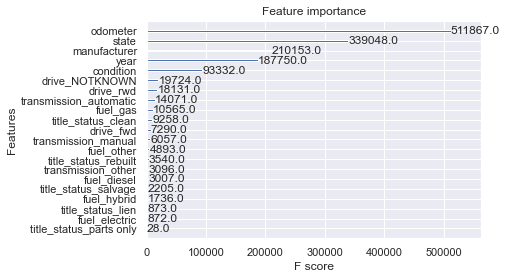

In [12]:
# ---- Feature importance for XGB Regressor ----
xgb.plot_importance(xgb_model_classifier)
plt.show()

## Observations

The increase in quality that the XGB Classifier provides starts to diminish after depth 20, where the F1 score starts to level out towards 68%. This indicates a decent quality of prediction where precision and recall are all leveling out towards 68%.

In [13]:
print("_______________Overall Fit of the model for all test set_______________")

goFString ="Goodness of Fit of Model       " 
fscoreString = "F1 Score (%)                   "
precisionString  ="Precision Score (%)            "
recallString = "Recall/Accuracy Score (%)      "
r2String  ="Explained Variance (R^2)       "
accString = "Mean model accuracy (%)        "
from sklearn.metrics import precision_recall_fscore_support

for resultSet, depth in zip(resultSets, depths):
      score = precision_recall_fscore_support(resultSet['actual'], resultSet['predict'], average='weighted')
      # Score array = {Precision, Recall, F1-Score, Support}
      # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

      goFString += "| Dataset {} \t".format(depth)
      r2String += "| {:^2.9f} \t".format(metrics.r2_score(resultSet['actual'], resultSet['predict']))
      fscoreString += "| {:^2.9f} \t".format(score[2]* 100.0)
      precisionString += "| {:^2.9f} \t".format(score[0]* 100.0)
      recallString += "| {:^2.9f} \t".format(score[1]* 100.0)
      accString += "| {:^2.8f} \t".format(accuracy_score(resultSet['actual'].astype(int), resultSet['predict'].astype(int))* 100.0)

# ---- Printing the concatenated metric strings for overall ----

print(goFString)
print(r2String)
print(fscoreString)
print(precisionString)
print(recallString)
print(accString)

_______________Overall Fit of the model for all test set_______________
Goodness of Fit of Model       | Dataset 1 	| Dataset 5 	| Dataset 10 	| Dataset 15 	| Dataset 20 	| Dataset 25 	
Explained Variance (R^2)       | 0.409166420 	| 0.662408452 	| 0.768012056 	| 0.819323842 	| 0.831928071 	| 0.834388107 	
F1 Score (%)                   | 27.373110871 	| 39.502887312 	| 54.598230010 	| 64.490608195 	| 67.920217246 	| 68.684328791 	
Precision Score (%)            | 28.092852953 	| 39.769960733 	| 54.600703000 	| 64.475472269 	| 67.908027299 	| 68.674485701 	
Recall/Accuracy Score (%)      | 30.307624101 	| 40.561760794 	| 54.979048382 	| 64.612502324 	| 67.961900948 	| 68.711296712 	
Mean model accuracy (%)        | 30.30762410 	| 40.56176079 	| 54.97904838 	| 64.61250232 	| 67.96190095 	| 68.71129671 	


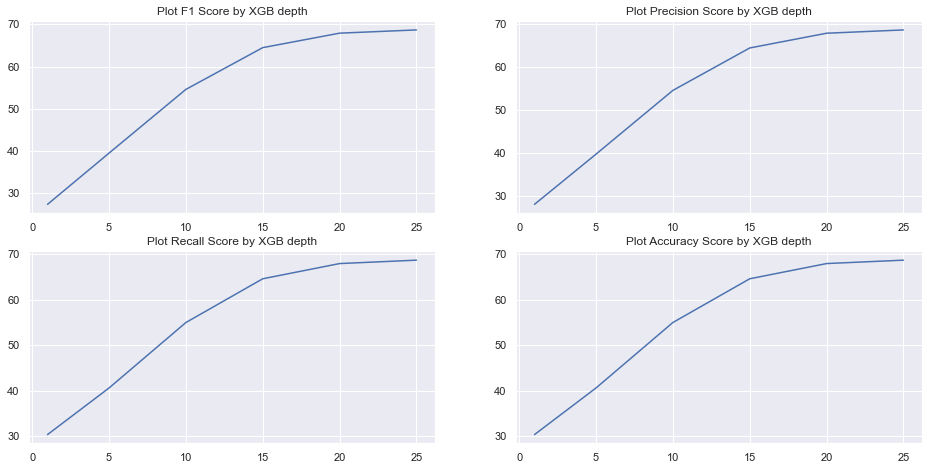

In [14]:
# visualizing the metrics on a line plot sorted by depth
# here we prepare the metrics into a list for plotting
f1 = [precision_recall_fscore_support(resultSet['actual'], resultSet['predict'], average='weighted')[2] * 100 for resultSet in resultSets]
precision = [precision_recall_fscore_support(resultSet['actual'], resultSet['predict'], average='weighted')[0] * 100  for resultSet in resultSets]
recall = [precision_recall_fscore_support(resultSet['actual'], resultSet['predict'], average='weighted')[1] * 100  for resultSet in resultSets]
acc = [accuracy_score(resultSet['actual'].astype(int), resultSet['predict'].astype(int))* 100.0  for resultSet in resultSets]

# creating sub plots for visualization
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
y_dict = {"F1 Score":f1, "Precision Score":precision,"Recall Score":recall,"Accuracy Score":acc}
i = 0
for row in axes:
    for ax in row:
        if(i >= len(y_dict)):
            ax.remove()
            continue
        key = list(y_dict.keys())[i]
        ax.plot(depths, y_dict[key])
        ax.set_title("Plot " + key + " by XGB depth")
        i += 1
plt.show()

The results from cross-validation show that the parameters we have chosen for the model are generally fitting, as there is very little standard deviation between each fold evaluation. Log loss for cross-validation diminishes with each depth, indicating a better quality of prediction, especially at depth 25, with a log loss mean of 0.2 for train and 0.96 for test.

In [15]:
#retrieve the final boosting metric from cross validation
for i, kfold in enumerate(kfoldResult):
    print("Depth " + str(depths[i]) + ":")
    display(kfoldResult[i].tail(1))

Depth 1:


,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
24,1.836791,0.000685,1.837511,0.002055


Depth 5:


,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
24,1.511858,0.000667,1.52601,0.004325


Depth 10:


,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
24,1.078239,0.002959,1.226282,0.003715


Depth 15:


,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
24,0.612566,0.002859,1.035926,0.005406


Depth 20:


,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
24,0.333709,0.002852,0.975356,0.004053


Depth 25:


,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
24,0.217619,0.001145,0.969552,0.003498


C:\Users\ngtze\AppData\Local\Temp\ipykernel_9132\3877977133.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)
C:\Users\ngtze\AppData\Local\Temp\ipykernel_9132\3877977133.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)
C:\Users\ngtze\AppData\Local\Temp\ipykernel_9132\3877977133.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)
C:\Users\ngtze\AppData\Local\Temp\ipykernel_9132\3877977133.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprec

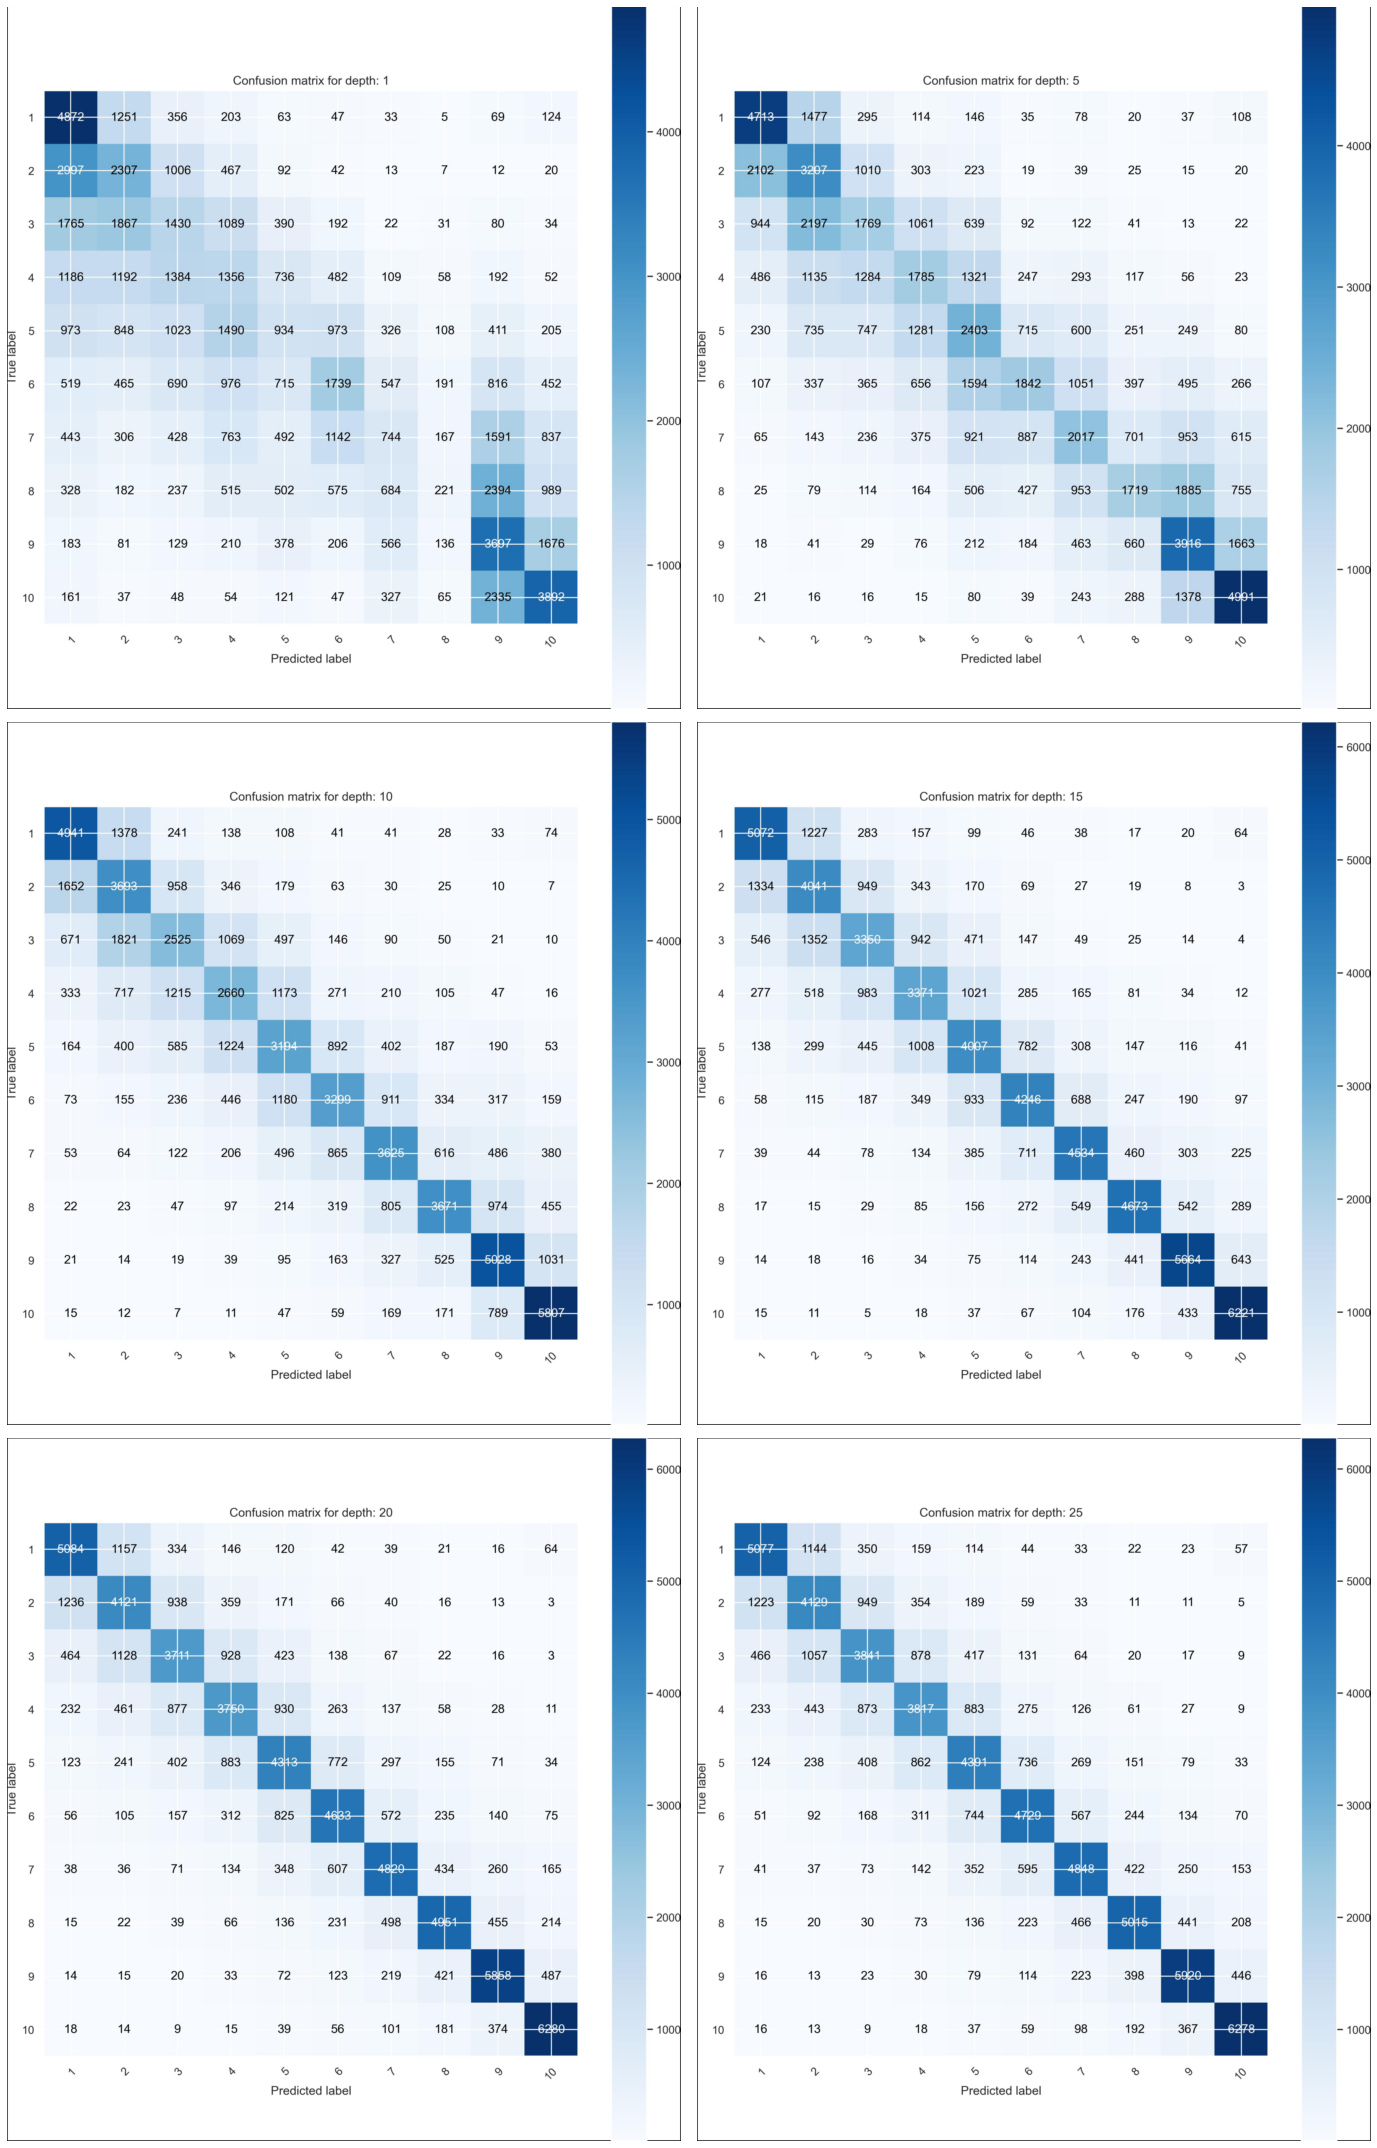

In [16]:
# Helper function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if not title:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return fig

np.set_printoptions(precision=2)
class_names = np.array(['0','1', '2', '3', '4', '5','6','7','8','9','10'])
foldername = "XGBConfusionMatrix"

#Make a dir if not found
if not os.path.exists(foldername):
    os.mkdir(foldername)
for resultSet, depth in zip(resultSets, depths):
    fig = plot_confusion_matrix(resultSet['actual'], resultSet['predict'], classes=class_names,
                        title='Confusion matrix for depth: '+ str(depth))
    fig.patch.set_linewidth(1)
    fig.patch.set_edgecolor('black')
    plt.savefig('{}/{}.jpg'.format(foldername, depth), bbox_inches='tight', pad_inches = 0, dpi=320)
    plt.close()  # prevents figure from being displayed when code cell is executed

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30))

# Display all saved confusion matrix in subplots
i = 0
for row in axes:
    for ax in row:
        if(i >= len(depths)):
            ax.remove()
            continue
        ax.imshow(mpimg.imread("{}/{}.jpg".format(foldername,depths[i])), interpolation="bilinear")
        ax.set_axis_off()
        i += 1
plt.tight_layout()
plt.axis('off')
plt.show()

## Observations
With the confusion matrix, we can see the True Positives and True Negatives getting better as the depths increase accordingly, which is aligned with our metrics. When comparing the XGB Classifier with the Decision Tree Classifier, the Log Loss for XGB is consistently lower than the Decision Tree Classifier, and you can see the Decision Tree Classifier Log Loss increasing significantly after depth 10, indicating it is a bad model. The XGB Classifier also has a better F1 Score than the Decision Tree Classifier for every depth.

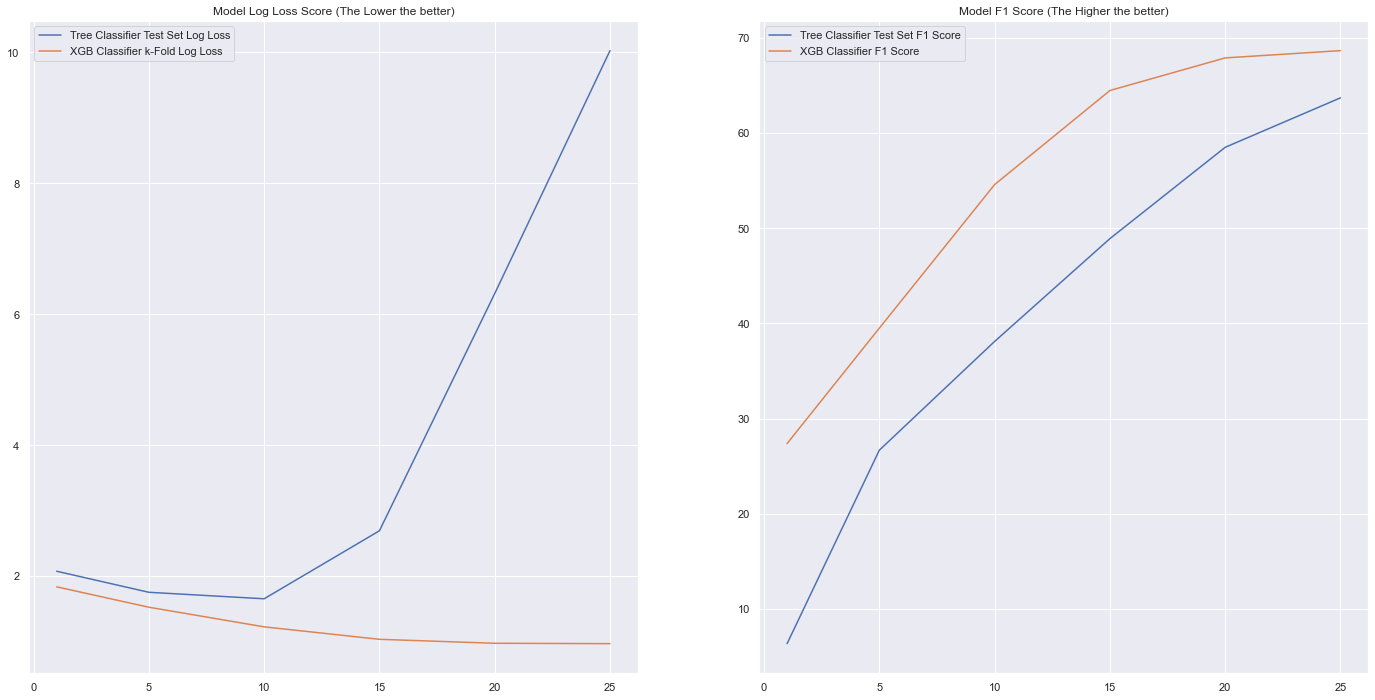

In [17]:
# visualizing the comparison of test set Log Loss value versus k-fold Log Loss on a line plot 
treeClassifierLogLoss = []
treeClassifierF1 = []
for depth in depths: 
    treeClassifier = DecisionTreeClassifier(criterion="gini", random_state=0,max_depth=depth)
    treeClassifier.fit(x_train,y_train)
    results=pd.DataFrame(treeClassifier.predict(x_test),columns=['predict'])
    results['actual']=list(test_tree['PRICECATEGORY'])
    treeClassifierLogLoss.append(log_loss(results['actual'], treeClassifier.predict_proba(x_test)))
    treeClassifierF1.append(f1_score(results['actual'], results['predict'],average='weighted')* 100.0)

kfoldResultMean = [result["test-mlogloss-mean"].tail(1) for result in kfoldResult]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
axes[0].plot(depths, treeClassifierLogLoss, label = "Tree Classifier Test Set Log Loss")
axes[0].plot(depths, kfoldResultMean, label = "XGB Classifier k-Fold Log Loss")
axes[0].set_title("Model Log Loss Score (The Lower the better)")
axes[0].legend()

axes[1].plot(depths, treeClassifierF1, label = "Tree Classifier Test Set F1 Score")
axes[1].plot(depths, f1, label = "XGB Classifier F1 Score")
axes[1].set_title("Model F1 Score (The Higher the better)")
axes[1].legend()
plt.show()

# End of XGB Exploration
This marks the end of this notebook.

We have done

- Testing of dataset with regressor model
    - XGB Regression

- Testing of dataset with a classifier model
    - XGB Classifier

Learning points

- Complex models like XGboost can return better prediction compared to basic models like tree classifier

We see that, overall on average, XGBoost performs better than Tree Classifiers for the various metrics we have tested against. This indicates that a more complex model such as XGboost could be one of the models that we can consider to predict the range of prices a resale car would likely be listed at.

Here we conclude the end of our mini project. Lessons learnt and conlusions will be presented further in the video and the next notebook.